# An Introduction to Neural Networks
---
# 03 - Multilayer Perceptron

Vamos esquentar as coisas!
Nesse tutorial, iremos estudar a evolução da Singlelayer Perceptron: a **Multilayer Perceptron** (SLP). Essa é uma das arquiteturas de Rede Neural mais populares até hoje, e é de utilização genérica (pode servir para diversas aplicações).

Diferentemente da SLP, que só funciona bem para problemas que são linearmente separáveis, essa Rede Neural é capaz de realizar classificações mais complexas, mesmo que as _decisions boundaries_ tenham formatos menos "comportados". Essa característica da MLP advém do fato de que a arquitetura dessa rede possui uma camada extra entre a _Camada de Entrada_ e a _Camada de Saída_, denominada _Camada Oculta_, na qual cada neurônio acumula (como seu Potencial de Rede), uma combinação linear das ativações da camada anterior. Como as ativações são não-lineares (devido à Sigmoide), o Potencial de Rede na camada oculta são transformaçoes não-lineares dos atributos de uma observação. Abaixo, uma illustração da Multilayer Perceptron.

<img src="../slides/imgs/mlp_01.png" alt="singlelayer perceptron" width="500px"/>

Neste notebook, iremos modificar algumas da funções auxiliares implementadas pelo Singlelayer Perceptron para incluir a ação da Camada Oculta. Além disso, iremos desenvolver o algoritmo especial de treinamento de Redes Neurais multicamadas: o **Backpropagation**. Após isso, exibiremos o comportamento dessa rede a um comum problema de _Classificação Não-Linear_, que não pode ser resolvido por Redes Neurais simples como o SLP.

### Sumário
* [Parte 1 - Funções Básicas de Redes Neurais Multicamadas](#Parte-1---Funções-Básicas-de-Redes-Neurais-Multicamada)
* [Parte 2 - Treinando a Rede Neural Multicamada](#Parte-2---Treinando-a-Rede-Neural-Multicamada)
* [Parte 3 - Classificação Binária com MLP](#Parte-3---Classificação-Binária-com-MLP)


### Bibliotecas, Variáveis Importantes e Funções Auxiliares

In [10]:
## BIBLIOTECAS ##
import pandas as pd                 # <-- Representação e Manipulação dos Dados
import numpy as np                  # <-- Biblioteca para Operações Matriciais e Complexas
import matplotlib.pyplot as plt     # <-- Biblioteca para Visualização de Dados

## VARIÁVEIS IMPORTANTES ##
colorpad = ["#d11141", "#00aedb", "#00b159", "#f37735", "#ffc425"]
colorpadBG = ["#00aedb50", "#d1114150", "#00b15950", "#f3773550", "#ffc42550"]

## FUNÇÕES AUXILIARES ##
# Plota um fundo colorido para as visualizações
def plotContour(X, model, theta, nClasses=2):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = model(np.c_[xx.ravel(), yy.ravel()], theta, False)[-1]
    Z = Z.reshape(xx.shape)

    plt.contour(xx, yy, Z, colors="#2A2A2A", linewidths=2)
    plt.contourf(xx, yy, Z, levels=range(-1,nClasses), colors=colorpadBG)
    
# Definição da Função Sigmoide
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Definição da Função de Cálculo de Acurácia
def accuracyFunction(X, y, W):
    Y_pred = forward(X, W, False)[-1]
    return 100 * (1 - (1 / np.size(y)) * np.sum((Y_pred - y) ** 2))
    
# Essa linha abaixo é apenas para que os 
# plots sejam gerados na mesma célula do código
%matplotlib inline

### Datasets

Neste tutorial, utilizaremos um dataset artificial, criado apenas para servir como base à explicação dos conceitos relacionados ao treino de Redes Neurais de multicamadas. 

**Obs.:** Note como os dados não podem ser separados por uma linha reta, como era o caso dos dados que utilizamos no tutorial do SLP.  
**Obs.2:** O código abaixo já está pronto. Para mais detalhes sobre como resgatar e manipular dados de arquivos, refira-se ao Tutorial 01.

In [2]:
## CARREGANDO E PRÉ-PROCESSANDO OS DADOS ##
# Carregando os dados a partir do arquivo .csv
data = pd.read_csv("../datasets/data_02.csv")

# Armazenando as dimensões dos dados
m = data.shape[0]
n = data.shape[1]-1

# Transformando as Classes em Números
data["Class"] = data["Class"].astype('category').cat.codes

# Separação do Conjunto de Treino e Conjunto de Teste
np.random.seed(2)
trainingSize = int(0.8 * m)
indexes = np.random.randint(0, m, m)

trainData = data.iloc[indexes[:trainingSize]]
testData = data.iloc[indexes[trainingSize:]]

# Obtendo matrizes (formato Numpy) correspondentes
X_train = trainData.iloc[:,:-1].values
y_train = trainData.iloc[:, -1].values

X_test = testData.iloc[:,:-1].values
y_test = testData.iloc[:, -1].values

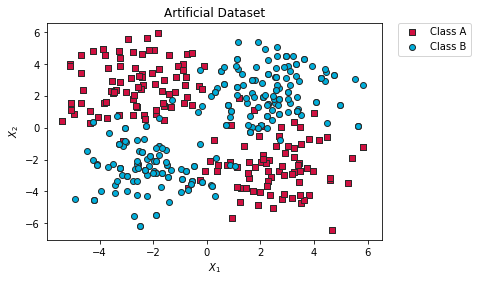

In [3]:
## VISUALIZAÇÃO CONDICIONADA COM O MATPLOTLIB E NUMPY ##
plt.figure()

a_class = np.where(y_train == 1)
b_class = np.where(y_train == 0)

plt.title("Artificial Dataset"); plt.xlabel("$X_1$"); plt.ylabel("$X_2$")

plt.scatter(X_train[a_class,0], X_train[a_class,1], marker="s", color=colorpad[0], edgecolor="#2A2A2A", label="Class A")
plt.scatter(X_train[b_class,0], X_train[b_class,1], marker="o", color=colorpad[1], edgecolor="#2A2A2A", label="Class B")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

---
## Parte 1 - Funções Básicas de Redes Neurais Multicamada

As Redes Neurais multicamadas possuem camadas intermediárias (chamadas de _Camadas Ocultas_) que são resultados de um processo de ativação dos neurônios das camadas anteriores. Por esse motivo, a Rede Neural é representada por uma **tensor de pesos** (matriz com 3 ou mais dimensões), onde cada elemento é uma matrix representando as transições entre duas camadas, e cada coluna dessas matrizes representam os pesos das sinapses de uma camada para um neurônio. Assim como anteriormente, essa matriz também precisa ser calculada automaticamente pelo processo de aprendizagem.

Para isso, implementaremos as duas principais funções de uma Rede Neural multicamada:

* **Forward Propagation (Propagação Direta):** essa função é responsável por realizar a ativação de cada camada da Rede Neural, desde a Camada de Entrada até a Camada de Saída, e retornar o valor armazenado em cada um desses Neurônios. Perceba que o que é o "passado adiante" aqui são os sinais de entrada (atributos) de uma observação recebida pela Rede, até obtermos a probabilidade da observação pertencer a cada classe.

* **Backpropagation (Propagação Inversa):** esse é o [algoritmo](https://en.wikipedia.org/wiki/Backpropagation#Pseudocode) mais popular para calcular os gradientes dos pesos de uma Rede Neural multicamada. Foi utilizado em Redes Neurais primeiramente em 1986, que foi um evento marcante na história dessa ciência, e até hoje é extremamente popular. Esse algoritmo consiste em calcular, da última até a primeira camada, o erro acumulado em cada Neurônio. Isso é feito ao calcular a diferença entre a classe prevista e a classe real (o erro da Camada de Saída), e então "passar para trás" o valor desse erro ponderado pelos pesos de cada ativação. Esses erros podem ser diretamente utilizados para calcular o gradiente (multiplicando o erro pelo valor do atributo), e então utilizar esses gradientes para treinar a rede utilizando Gradiente Descendente.

Obs.: Iremos tratar apenas do case onde há uma única Camada Oculta, para facilitar as implementações e explicações.

### Forward Propagation

In [4]:
# Definição da Função de Forward Propagation
def forward(X, W, probs=True):
    if(X.shape[1] != W[0].shape[0]): 
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        
    A = []
    A.append(X)
    for i in range(0, len(W)):
        Z = sigmoid(np.matmul(A[-1], W[i]))
        if (i < len(W)-1): 
            Z = np.hstack([np.ones([Z.shape[0], 1]), Z])
            
        A.append(Z)
    
    if not probs: A[-1] = (A[-1] > 0.5).astype(int)
    return A

# Teste da Forward Propagation
X = np.array([[ 5, 4, 3,  2],
              [ 1, 2, 3,  4],
              [-2, 0, 1, -1]])    # Observação
W = []                          # Tensor de Pesos
W.append(np.array([[0.5,-0.7],
                   [  1,   2], 
                   [  3,  -4],
                   [ -4,   3],
                   [  2,  -2]]))  # 1ª Matriz: C. Entrada -> C. Oculta 
W.append(np.array([[2],
                   [2],
                   [2]]))       # 2ª Matriz: C. Oculta -> C. Saída

A = forward(X,W)

print("# Resultado das Ativações da Rede Neural #")
print("Camada de Entrada:\n", A[0])
print("Camada Oculta:\n", A[1])
print("Camada de Saída:\n", A[2])

# Resultado das Ativações da Rede Neural #
Camada de Entrada:
 [[ 1.  5.  4.  3.  2.]
 [ 1.  1.  2.  3.  4.]
 [ 1. -2.  0.  1. -1.]]
Camada Oculta:
 [[  1.00000000e+00   9.99925154e-01   1.54465265e-01]
 [  1.00000000e+00   9.70687769e-01   3.33480731e-03]
 [  1.00000000e+00   5.52778637e-04   5.74442517e-01]]
Camada de Saída:
 [[ 0.98672856]
 [ 0.98107277]
 [ 0.95890835]]


### Backpropagation

In [5]:
def backprop(A, y, W):
    E = []
    E.append(A[-1] - y)
    for i in range(len(W)-1, 0, -1):
        E.append(np.matmul(E[-1], W[i].T) * A[i] * (1-A[i]))
        E[-1] = E[-1][:,1:]
    return E[::-1]

# Teste da Forward Propagation
X = np.array([[ 5, 4, 3,  2],
              [ 1, 2, 3,  4],
              [-2, 0, 1, -1]])    # Observação
y = np.array([[1],[0],[1]])     # Classe da Observação
W = []                          # Tensor de Pesos
W.append(np.array([[0.5,-0.7],
                   [  1,   2], 
                   [  3,  -7],
                   [ -4,   3],
                   [  2,  -2]]))  # 1ª Matriz: C. Entrada -> C. Oculta 
W.append(np.array([[2],
                   [2],
                   [2]]))       # 2ª Matriz: C. Oculta -> C. Saída


A = forward(X,W)
E = backprop(A,y,W)

print("# Resultado dos Erros da Rede Neural #")
print("Erro na Camada Oculta:\n", E[0])
print("Erro na Camada de Saída:\n", E[1])

# Resultado dos Erros da Rede Neural #
Erro na Camada Oculta:
 [[ -2.69258826e-06  -4.03828682e-08]
 [  5.58219213e-02   1.62713546e-05]
 [ -4.54040591e-05  -2.00903903e-02]]
Erro na Camada de Saída:
 [[-0.01798881]
 [ 0.98094884]
 [-0.04109165]]


---
## Parte 2 - Treinando a Rede Neural Multicamada

In [11]:
###############################
#    Treinamento do MLP    #
###############################
def mlp_train(X, y, n_hidden, alpha=1e-3, maxIt=50000, tol=1e-5, verbose=False):
    # Armazena as dimensões dos dados (m -> exemplos, n -> atributos)
    m = X.shape[0]; n = X.shape[1]
    
    # Define o Histórico de Erros e algumas variáveis auxiliares
    errorHist = []
    previousMSE = 0
    it = 1;
    
    # Cria um atributo extra para todos os exemplos iguais a x_0 = 1
    X = np.hstack([np.ones([m,1]), X])
    y = y.reshape(-1,1)
    
    # Cria o vetor de pesos da Rede Neural (inicialização aleatória)
    W = [np.random.randn(n+1, n_hidden), np.random.randn(n_hidden+1, 1)]
    
    # Realiza o treino por Gradiente Descendente
    while(it <= maxIt):
        # 1. Calculamos a ativação de todos os neurônios (Forward Propagation) e 
        #    retropropagamos o erro da predição (Backpropagation)
        A = forward(X, W)
        E = backprop(A, y, W)
        
        # 2. Calculamos o erro MSE, a acurácia do modelo e adicionamos o resultado no histórico.
        actualMSE = (1/m) * np.sum(E[1]**2)
        actualAcc = accuracyFunction(X, y, W)
        errorHist.append(actualMSE)
        
        # 3. Realizamos o passo do Gradiente Descendente.        
        for i in range(0, 2):
            W[i] = W[i] - (alpha/m) * np.matmul(A[i].T, E[i])
        
        # 4. Imprimimos o resultado do treinamento a cada 50 épocas.
        if(it % 50 == 0 and verbose): 
            print("## Iteration", it, "##")
            print("MSE: \t", actualMSE)
            print("Accuracy: {0:.3f}%".format(actualAcc))
            print("Weights\nS -> H:\n", W[0], "\nH -> O:\n", W[1])
            print("\n")
        
        # 5. Verificamos uma possivel convergência do treinamento, e então encerramos o laço.
        if(abs(actualMSE - previousMSE) <= tol):
            print("## Iteration", it, "##")
            print("!!! Convergence reached !!!")
            print("MSE: \t", actualMSE)
            print("Accuracy: {0:.3f}%".format(actualAcc))
            print("Weights\nS -> H:\n", W[0], "\nH -> O:\n", W[1])
            print("\n")
            break;
            
        # 6. Atualizamos as variáveis auxiliares para as próximas iterações.
        previousMSE = actualMSE
        it +=1
    
    # Fim do Treinamento
    return (W, errorHist)

---
## Parte 3 - Classificação Binária com MLP

In [18]:
# Execução do Treinamento
[W, errorHist] = mlp_train(X_train, y_train, 20, alpha=0.1, verbose=False)

## Iteration 1206 ##
!!! Convergence reached !!!
MSE: 	 0.0541831127194
Accuracy: 93.958%
Weights
S -> H:
 [[-1.16976935 -0.1686476  -1.2283604  -0.58991187  1.60213498 -0.95215063
   2.73273783 -0.19417682  0.51877433 -1.11100204  1.68107512 -3.13014416
   0.48654905  0.87882077  1.79002188 -2.42843844  1.6445677   0.67584608
   1.03431988 -1.29354471]
 [ 0.45389578 -2.48678386 -0.53751363  0.60971761 -0.85660718 -1.70026148
   1.01253406  0.24207935  1.39587749 -0.96405604 -0.57593539 -1.398413
  -0.29309342  0.55820488  1.06748675 -0.95002599  0.83183241  1.50875839
  -2.52387187  0.68284828]
 [-0.45847137  1.83150338 -0.98176088  2.06727592  0.80438807  0.4711046
  -0.83351429 -0.32494311  0.93720422 -0.61900837 -0.77238549 -1.11765922
  -0.47645468 -1.14871649 -0.86598404  0.77255293  0.69992314  0.723435
  -1.22380033 -1.1871263 ]] 
H -> O:
 [[ 1.07953117]
 [ 0.62278961]
 [-1.13074098]
 [-0.32338062]
 [-1.24034026]
 [-2.26331176]
 [ 0.75924257]
 [-2.35347359]
 [ 0.35141916]
 [-0.

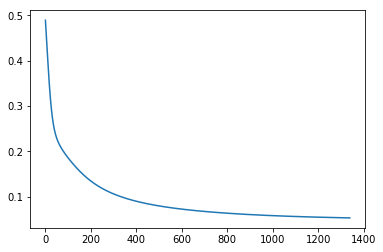

In [17]:
plt.figure()
plt.plot(errorHist)
plt.show()

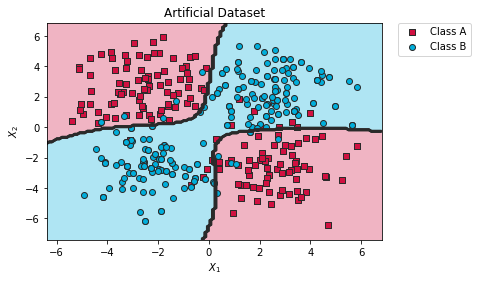

In [16]:
## VISUALIZAÇÃO DA CLASSIFICAÇÃO ##
plt.figure()

plt.title("Artificial Dataset"); plt.xlabel("$X_1$"); plt.ylabel("$X_2$")

plotContour(X_train, forward, W)

a_class = np.where(y_train == 1)
b_class = np.where(y_train == 0)

plt.scatter(X_train[a_class,0], X_train[a_class,1], marker="s", color=colorpad[0], edgecolor="#2A2A2A", label="Class A")
plt.scatter(X_train[b_class,0], X_train[b_class,1], marker="o", color=colorpad[1], edgecolor="#2A2A2A", label="Class B")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
